In [3]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#tf.config.list_physical_devices('GPU')

In [ ]:
data_X_train = np.load("data/X_train.npz", allow_pickle=True)['arr_0']
data_y_train = np.load("data/bboxes_train.npz", allow_pickle=True)['arr_0']
data_labels_train = np.load("data/labels_train.npz", allow_pickle=True)['arr_0']
print(data_X_train.shape)
print(data_y_train.shape)
print(data_labels_train.shape)


(235755, 128, 128, 1)
(235755, 6, 4)
(235755, 6)


In [ ]:
X_train, X_val, y_train_bboxes, y_val_bboxes, y_train_labels, y_val_labels = train_test_split(
    data_X_train, data_y_train, data_labels_train,
    test_size=0.2,
    random_state=5,
    shuffle=True
)
data_X_train = None
data_y_train = None
data_labels_train = None


In [ ]:
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature_list(values):
    return tf.train.Feature(float_list=tf.train.FloatList(value=values))

def _int32_feature_list(values):
    return tf.train.Feature(int_list=tf.train.Int64List(value=values))



def serialize_example(image, bboxes, classes):

    image = image.tobytes()
    bboxes_flat = bboxes.reshape(-1).tolist()
    classes_list = classes.astype(np.int32).tolist()

    feature = {
        "image_raw": _bytes_feature(image),
        "bboxes": _float_feature_list(bboxes_flat),
        "classes": _int32_feature_list(classes_list),
    }

    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example.SerializeToString()

def write_tfrecord(filename, images, boxes, labels):
    with tf.io.TFRecordWriter(filename) as writer:
        for image, box, label in zip(images, boxes, labels):
            writer.write(serialize_example(image, box, label))

write_tfrecord("data/train.tfrecord", X_train, y_train_bboxes, y_train_labels)
write_tfrecord("data/val.tfrecord", X_val, y_val_bboxes, y_val_labels)

In [ ]:
def parse_example(example):
    feature = {
        "image_raw": tf.io.FixedLenFeature([], tf.string),
        "bboxes": tf.io.FixedLenFeature([24], tf.float32),
        "classes": tf.io.FixedLenFeature([6], tf.int64),
    }

    parsed = tf.io.parse_single_example(example, feature)

    image = tf.io.decode_raw(parsed["image_raw"], tf.float32)
    image = tf.reshape(image, (128, 128, 1))
    bboxes = tf.reshape(parsed["bboxes"], (6,4))
    classes = tf.cast(parsed["classes"], tf.int16)

    return image, {
        "bboxes": bboxes,
        "classes": classes
    }

In [50]:
ds_train = (
    tf.data.TFRecordDataset("data/train.tfrecord", num_parallel_reads=tf.data.AUTOTUNE)
    .map(parse_example, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)
ds_val = (
    tf.data.TFRecordDataset("data/val.tfrecord", num_parallel_reads=tf.data.AUTOTUNE)
    .map(parse_example, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)


In [123]:
@tf.keras.utils.register_keras_serializable()
def weighted_sparse_categorical_crossentropy(y_true, y_pred):
    class_weights = [0.1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
    class_weights_tensor = tf.constant(class_weights, dtype=tf.float32)
    y_true_flat = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
    y_pred_flat = tf.reshape(y_pred, [-1, y_pred.shape[-1]])

    scce = tf.keras.losses.sparse_categorical_crossentropy(
        y_true_flat, y_pred_flat, from_logits=False
    )

    weights = tf.gather(class_weights_tensor, y_true_flat)
    weighted_loss = scce * weights

    return tf.reduce_mean(weighted_loss)

In [ ]:
def predModel(input_shape=(128,128,1), num_classes = 11, max_digits = 6):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(64, (3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(128, (3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(256, (3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(512, (3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    #BBOX
    bbox = tf.keras.layers.Dense(128, activation='relu')(x)
    bbox = tf.keras.layers.Dropout(0.1)(bbox)
    bbox = tf.keras.layers.Dense(max_digits * 4)(bbox)
    bbox_output = tf.keras.layers.Reshape((max_digits, 4), name="bboxes")(bbox)

    #CLASSIFICATION
    cls = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    cls = tf.keras.layers.Dropout(0.4)(cls)
    cls = tf.keras.layers.Dense(max_digits * num_classes, activation='softmax')(cls)
    cls_output = tf.keras.layers.Reshape((max_digits, num_classes), name="classes")(cls)

    return tf.keras.Model(inputs, [bbox_output, cls_output])

model = predModel()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4, amsgrad=True),
    loss={
        "bboxes": tf.losses.Huber(delta=0.05),
        #"classes": weighted_sparse_categorical_crossentropy
        "classes": "sparse_categorical_crossentropy"
    },
    loss_weights = {
        "bboxes": 0.05,
        "classes": 1.0
    },
    metrics={
        "bboxes": ["mse"],
        "classes": ["accuracy"]
    },
)


model.fit(
    ds_train,
    epochs=30,
    validation_data=ds_val,
    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_classes_accuracy', factor=0.3, patience=3,min_lr=1e-6, mode='max'),
        tf.keras.callbacks.EarlyStopping(monitor='val_classes_accuracy', patience=10, restore_best_weights=True, mode='max')
    ]
)





In [7]:
data_X_test = np.load("data/X_test.npy", allow_pickle=True)
data_bboxes_test = np.load("data/y_test.npy", allow_pickle=True)
data_labels_test = np.load("data/labels_test.npy", allow_pickle=True)
print(data_X_test.shape)
print(data_bboxes_test.shape)
print(data_labels_test.shape)
ds_test = tf.data.Dataset.from_tensor_slices((data_X_test, {"bboxes": data_bboxes_test, "classes": data_labels_test}))
ds_test = ds_test.batch(64).prefetch(tf.data.AUTOTUNE)


(13068, 128, 128, 1)
(13068, 6, 4)
(13068, 6)


In [85]:
write_tfrecord("data/test.tfrecord", data_X_test, data_bboxes_test, data_labels_test)
ds_test = (
    tf.data.TFRecordDataset("data/test.tfrecord", num_parallel_reads=1)
    .map(parse_example, num_parallel_calls=1)
    .batch(64, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

In [115]:
results = model.evaluate(ds_test)
print(results)
print('Test loss: %.4f accuracy: %.4f' % (results[2], results[4]))
data_X_test = None
data_y_test = None
data_labels_test = None

205/205 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - bboxes_loss: 0.0011 - bboxes_mse: 0.0051 - classes_accuracy: 0.8685 - classes_loss: 0.4456 - loss: 0.4606
[0.46056073904037476, 0.0011391855077818036, 0.44557932019233704, 0.005090861115604639, 0.8685466051101685]
Test loss: 0.4456 accuracy: 0.8685


In [124]:
model.save('models/svhnModel_final2.keras')

In [ ]:
print(model.history.history.keys())
plt.figure(figsize=(10,5))
plt.plot(model.history.history['loss'], label = 'train loss')
plt.plot(model.history.history['val_loss'], label = 'val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total Loss Curve')
plt.legend()
plt.grid()
plt.show()

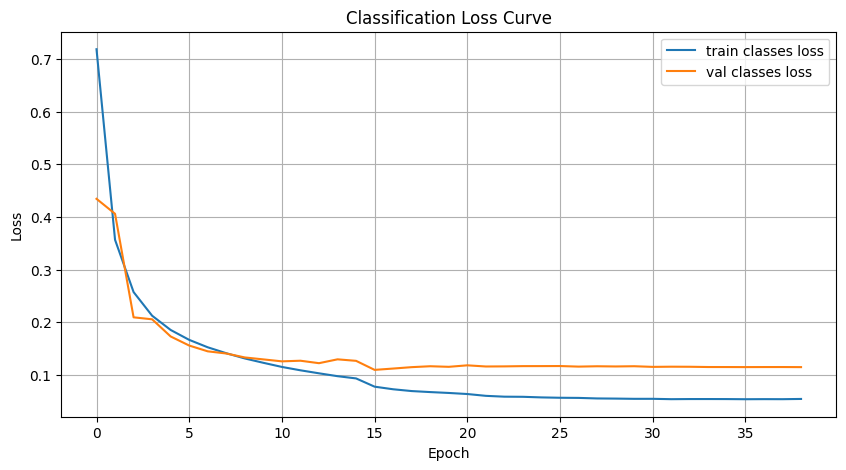

In [104]:
plt.figure(figsize=(10,5))
plt.plot(model.history.history['classes_loss'], label = 'train classes loss')
plt.plot(model.history.history['val_classes_loss'], label = 'val classes loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Classification Loss Curve')
plt.legend()
plt.grid()
plt.show()

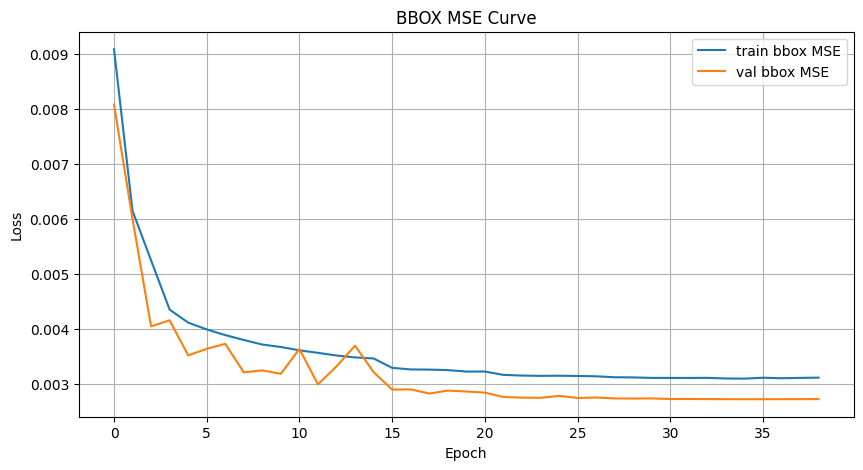

In [105]:
plt.figure(figsize=(10,5))
plt.plot(model.history.history['bboxes_mse'], label = 'train bbox MSE')
plt.plot(model.history.history['val_bboxes_mse'], label = 'val bbox MSE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('BBOX MSE Curve')
plt.legend()
plt.grid()
plt.show()


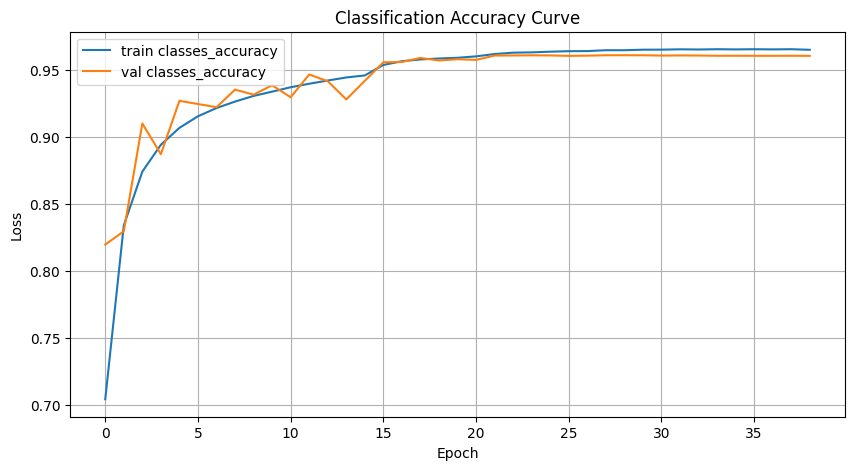

In [106]:
plt.figure(figsize=(10,5))
plt.plot(model.history.history['classes_accuracy'], label = 'train classes_accuracy')
plt.plot(model.history.history['val_classes_accuracy'], label = 'val classes_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Classification Accuracy Curve')
plt.legend()
plt.grid()
plt.show()


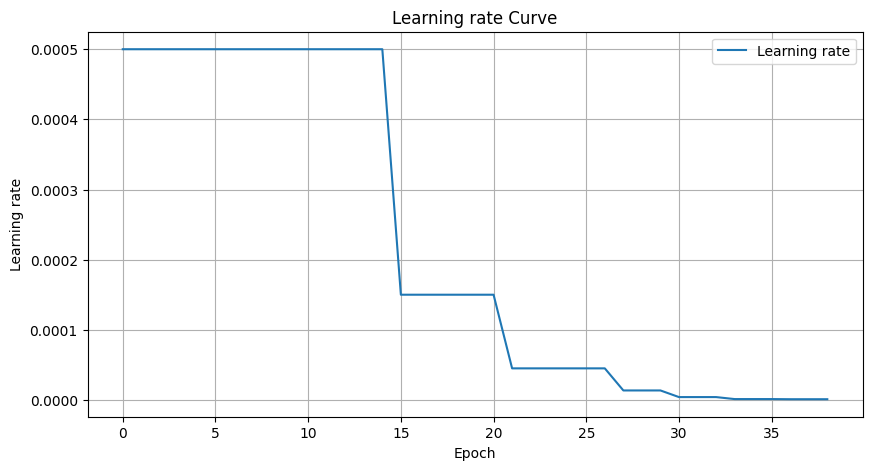

In [107]:
plt.figure(figsize=(10,5))
plt.plot(model.history.history['learning_rate'], label = 'Learning rate')
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.title('Learning rate Curve')
plt.legend()
plt.grid()
plt.show()

In [8]:
model = tf.keras.models.load_model('models/svhnModel_full.keras')
data_labels_test = np.load("data/labels_test.npy", allow_pickle=True)
labels_pred = model.predict(ds_test)
y_pred = labels_pred[1]
y_pred = np.argmax(y_pred, axis=2)  

205/205 ━━━━━━━━━━━━━━━━━━━━ 57s 274ms/step


In [ ]:
digit_acc = np.mean(data_labels_test == y_pred, axis=0)

Accuracy for digit 0: 0.7398
Accuracy for digit 1: 0.6510
Accuracy for digit 2: 0.8345
Accuracy for digit 3: 0.9861
Accuracy for digit 4: 0.9998
Accuracy for digit 5: 1.0000


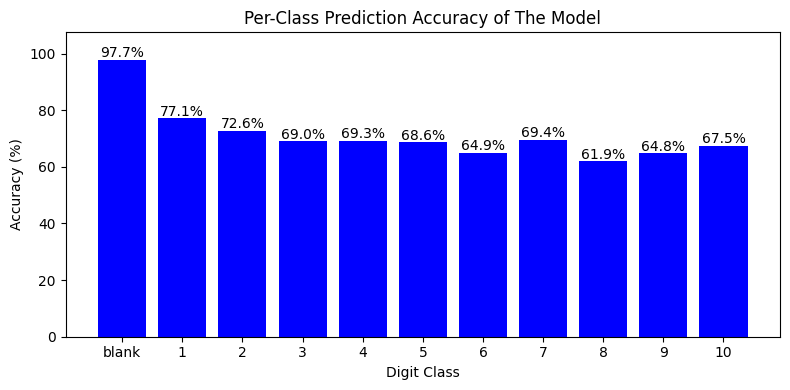

In [14]:
class_accuracy = []
for i in range(11):
    mask = (data_labels_test == i)
    class_accuracy.append(np.mean(y_pred[mask] == i))
class_accuracy_percentages = [acc * 100 for acc in class_accuracy]
classes = ['blank', '1', '2', '3', '4','5','6','7','8','9','10']

plt.figure(figsize=(8, 4))
plt.bar(classes, class_accuracy_percentages, color='blue')

plt.xlabel("Digit Class")
plt.ylabel("Accuracy (%)")
plt.title("Per-Class Prediction Accuracy of The Model")

for cls, val in zip(classes, class_accuracy_percentages):
    plt.text(cls, val + 1, f"{val:.1f}%", ha='center')
plt.margins(y=0.1)
plt.tight_layout()
plt.savefig("class_accuracy.svg", format="svg")
plt.show()

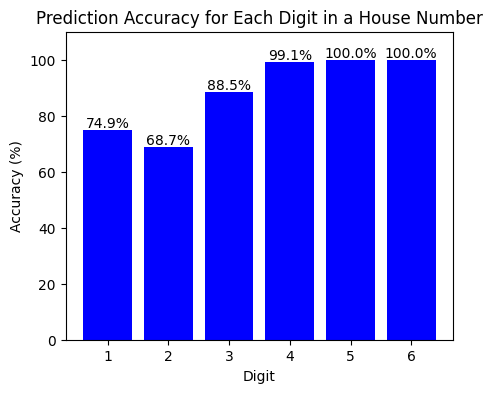

In [13]:
digit_acc = np.mean(data_labels_test == y_pred, axis=0)
digit_accuracy_percentages = [acc * 100 for acc in digit_acc]
digit_classes = ['1', '2', '3', '4','5','6']


plt.figure(figsize=(5, 4))
plt.bar(digit_classes, digit_accuracy_percentages, color='blue')

plt.xlabel("Digit")
plt.ylabel("Accuracy (%)")
plt.title("Prediction Accuracy for Each Digit in a House Number")

for cls, val in zip(digit_classes, digit_accuracy_percentages):
    plt.text(cls, val + 1, f"{val:.1f}%", ha='center')
plt.margins(y=0.1)
plt.savefig("digit_accuracy.svg", format="svg")
plt.show()


In [22]:
model.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 128, 128,  │        320 │ input_layer_11[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_55[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_55 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_44    │ (None, 64, 64,    │          0 │ re_lu_55[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_44… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_56[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_56 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_45    │ (None, 32, 32,    │          0 │ re_lu_56[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_45… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_57[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_57 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_46    │ (None, 16, 16,    │          0 │ re_lu_57[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 16, 16,    │    295,168 │ max_pooling2d_46… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_58[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_58 (ReLU)     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_47    │ (None, 8, 8, 256) │          0 │ re_lu_58[0][0]  

 Total params: 7,150,122 (27.28 MB)

 Trainable params: 1,787,034 (6.82 MB)

 Non-trainable params: 1,984 (7.75 KB)

 Optimizer params: 5,361,104 (20.45 MB)